**installing required packages**

In [559]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Importing Packages**

In [560]:
import pandas as pd
import datetime
import opendatasets as od
import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib_venn import venn2

%matplotlib inline

**downloading the datasets into Pandas DataFrames**

In [561]:
city_url="https://raw.githubusercontent.com/DataGlacier/DataSets/main/City.csv"
cab_data_url = 'https://raw.githubusercontent.com/DataGlacier/DataSets/main/Cab_Data.csv'
customer_id_url="https://raw.githubusercontent.com/DataGlacier/DataSets/main/Customer_ID.csv"
transaction_id_url="https://raw.githubusercontent.com/DataGlacier/DataSets/main/Transaction_ID.csv"

city_df = pd.read_csv(city_url,index_col=False)
cab_data_df = pd.read_csv(cab_data_url,index_col=False)
customer_id_df = pd.read_csv(customer_id_url,index_col=False)
transaction_id_df = pd.read_csv(transaction_id_url,index_col=False)


##### there are invalid dates in Cab_Data that should be mapped according to range date specified to real dates
cab_data_df['Date of Travel'] = pd.TimedeltaIndex(cab_data_df['Date of Travel'], unit='d') + datetime.datetime(1899,12,30)

**Additionally we maybe interested to evaluate results on the US holidays**
this dataset is available on Kaggle, after downloading it it should be filtered on our interested time period and drop unneccesary columns

In [562]:
od.download("https://www.kaggle.com/datasets/donnetew/us-holiday-dates-2004-2021/download?datasetVersionNumber=1")
holidays_df = pd.read_csv('./us-holiday-dates-2004-2021/US Holiday Dates (2004-2021).csv')
holidays_df=holidays_df.loc[(holidays_df['Year'] >= 2016) & (holidays_df['Year'] <= 2018)]
holidays_df=holidays_df.drop(columns=['Year', 'Day','Month','WeekDay']).reset_index().drop(columns=['index'])
holidays_df=holidays_df.rename(columns={'Date':'Date of Travel'})
holidays_df['Date of Travel']=pd.to_datetime( holidays_df['Date of Travel'])

Skipping, found downloaded files in "./us-holiday-dates-2004-2021" (use force=True to force download)


**Another addional Dataset is the US weather condition Dataset**
this additional dataset is also available on kaggle, after downloading it, and filtering the dataset on our interested time period and cities available on Cities dataframe we will have the resulted dataframe

In [563]:
od.download("https://www.kaggle.com/datasets/sobhanmoosavi/us-weather-events/download?datasetVersionNumber=3") #df20db1df43c74a3c973a4c705c707aa
weather_df = pd.read_csv('./us-weather-events/WeatherEvents_Jan2016-Dec2021.csv')
weather_df=weather_df.drop(columns=['EventId','Severity','Precipitation(in)','TimeZone','AirportCode','LocationLat',	'LocationLng'	,'ZipCode','County','EndTime(UTC)'])
weather_df['StartTime(UTC)'] = pd.to_datetime(weather_df['StartTime(UTC)']).dt.date
weather_df['StartTime(UTC)'] = pd.to_datetime(weather_df['StartTime(UTC)']) #remove hour part
weather_df['startY'] = weather_df['StartTime(UTC)'].dt.year # take the year in a new column
weather_df=weather_df.loc[(weather_df['startY'] >= 2016) & (weather_df['startY'] <= 2018)] #filter years
weather_df=weather_df.drop(columns=['startY']) # and drop created column
weather_df['City'] = weather_df['City'].str.upper()  #make it capital to match with our cities in our data frames
weather_df["City"] = weather_df['City'].astype(str) +" "+ weather_df["State"]
weather_df=weather_df.drop(columns=['State']) 
Cities_list = city_df['City'].tolist()
o=pd.DataFrame()
for c in Cities_list: # if City is in list of my cities in my main datasets keep them , otherwise ignore them
  o=o.append(weather_df[weather_df["City"].str.contains(c)],ignore_index = True)
weather_df=o
weather_df=weather_df.rename(columns={"StartTime(UTC)": "Date of Travel"})


Skipping, found downloaded files in "./us-weather-events" (use force=True to force download)


### **Lets have a look at our data frames and Cheking if columns that we consider critical consist any duplicates or NAN , also having an overall look at our dataframes with .info() and .describe()**

city_df:

In [564]:
print(city_df.head(5))
print(city_df.info())
print(city_df.describe())
print('any null ... ? :', city_df.isnull().values.any())
print('any duplicates...? :', city_df.iloc[:, 0].duplicated().sum()) # on name of city

             City   Population      Users
0     NEW YORK NY   8,405,837    302,149 
1      CHICAGO IL   1,955,130    164,468 
2  LOS ANGELES CA   1,595,037    144,132 
3        MIAMI FL   1,339,155     17,675 
4  SILICON VALLEY   1,177,609     27,247 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   City        20 non-null     object
 1   Population  20 non-null     object
 2   Users       20 non-null     object
dtypes: object(3)
memory usage: 608.0+ bytes
None
               City   Population      Users
count            20           20         20
unique           20           20         20
top     NEW YORK NY   8,405,837    302,149 
freq              1            1          1
any null ... ? : False
any duplicates...? : 0


Cab_data_df:




In [565]:
print(cab_data_df.head(5))
print(cab_data_df.info())
print(cab_data_df.describe())
print('any null ... ? :',cab_data_df.isnull().values.any())
print('any duplicates...? :',cab_data_df.iloc[:, 0].duplicated().sum()) # other columns can be duplicated but transactions should be unique

   Transaction ID Date of Travel   Company        City  KM Travelled  \
0        10000011     2016-01-08  Pink Cab  ATLANTA GA         30.45   
1        10000012     2016-01-06  Pink Cab  ATLANTA GA         28.62   
2        10000013     2016-01-02  Pink Cab  ATLANTA GA          9.04   
3        10000014     2016-01-07  Pink Cab  ATLANTA GA         33.17   
4        10000015     2016-01-03  Pink Cab  ATLANTA GA          8.73   

   Price Charged  Cost of Trip  
0         370.95       313.635  
1         358.52       334.854  
2         125.20        97.632  
3         377.40       351.602  
4         114.62        97.776  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359392 entries, 0 to 359391
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Transaction ID  359392 non-null  int64         
 1   Date of Travel  359392 non-null  datetime64[ns]
 2   Company         359392 non-null  object   

customer_id_df :

In [566]:
print(customer_id_df.head(5))
print(customer_id_df.info())
print(customer_id_df.describe())
print('any null ... ? :',customer_id_df.isnull().values.any())
print('any duplicates...? :',customer_id_df.iloc[:, 0].duplicated().sum()) # customer ids should be unique, others can be duplicated

   Customer ID Gender  Age  Income (USD/Month)
0        29290   Male   28               10813
1        27703   Male   27                9237
2        28712   Male   53               11242
3        28020   Male   23               23327
4        27182   Male   33                8536
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49171 entries, 0 to 49170
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Customer ID         49171 non-null  int64 
 1   Gender              49171 non-null  object
 2   Age                 49171 non-null  int64 
 3   Income (USD/Month)  49171 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB
None
        Customer ID           Age  Income (USD/Month)
count  49171.000000  49171.000000        49171.000000
mean   28398.252283     35.363121        15015.631856
std    17714.137333     12.599066         8002.208253
min        1.000000     18.000000         2000.0000

Transaction_ID

In [567]:
print(transaction_id_df.head(5))
print(transaction_id_df.info())
print(transaction_id_df.describe())
print('any null ... ? :',transaction_id_df.isnull().values.any())
print('any duplicates...? :',transaction_id_df.iloc[:, 0].duplicated().sum()) # each transaction is unique and shouldnt be duplicated

   Transaction ID  Customer ID Payment_Mode
0        10000011        29290         Card
1        10000012        27703         Card
2        10000013        28712         Cash
3        10000014        28020         Cash
4        10000015        27182         Card
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440098 entries, 0 to 440097
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Transaction ID  440098 non-null  int64 
 1   Customer ID     440098 non-null  int64 
 2   Payment_Mode    440098 non-null  object
dtypes: int64(2), object(1)
memory usage: 10.1+ MB
None
       Transaction ID    Customer ID
count    4.400980e+05  440098.000000
mean     1.022006e+07   23619.513120
std      1.270455e+05   21195.549816
min      1.000001e+07       1.000000
25%      1.011004e+07    3530.000000
50%      1.022006e+07   15168.000000
75%      1.033008e+07   43884.000000
max      1.044011e+07   60000.000000
any null ...

Weather_df:

In [568]:
print(weather_df.head(5))
print(weather_df.info())
print(weather_df.describe())
print('any null ... ? :',weather_df.isnull().values.any())

   Type Date of Travel         City
0  Cold     2016-01-08  NEW YORK NY
1  Cold     2016-01-09  NEW YORK NY
2  Rain     2016-01-09  NEW YORK NY
3  Rain     2016-01-10  NEW YORK NY
4  Rain     2016-01-10  NEW YORK NY
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52013 entries, 0 to 52012
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Type            52013 non-null  object        
 1   Date of Travel  52013 non-null  datetime64[ns]
 2   City            52013 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.2+ MB
None
         Type       Date of Travel         City
count   52013                52013        52013
unique      7                 1094           19
top      Rain  2018-02-11 00:00:00  NEW YORK NY
freq    37270                  165         6503
first     NaN  2016-01-01 00:00:00          NaN
last      NaN  2018-12-31 00:00:00          NaN
any null ... ? :

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  This is separate from the ipykernel package so we can avoid doing imports until


holidays_df:

In [569]:
print(holidays_df.head(5))
print(holidays_df.describe())
print('any null ... ? :',holidays_df.isnull().values.any())


  Date of Travel        Holiday
0     2016-07-04    4th of July
1     2017-07-04    4th of July
2     2018-07-04    4th of July
3     2016-12-25  Christmas Day
4     2017-12-25  Christmas Day
             Date of Travel            Holiday
count                    57                 57
unique                   56                 18
top     2017-04-16 00:00:00  Labor Day Weekend
freq                      2                  6
first   2016-01-01 00:00:00                NaN
last    2018-12-31 00:00:00                NaN
any null ... ? : False


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


Fortunatly there are no Nan values to be treated at this point of time Lets have a master dataframe consisiting of all the features

In [570]:
master_df = cab_data_df.merge(transaction_id_df, on= 'Transaction ID').merge(customer_id_df, on ='Customer ID').merge(city_df, on = 'City')
master_df

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month),Population,Users
0,10000011,2016-01-08,Pink Cab,ATLANTA GA,30.45,370.95,313.6350,29290,Card,Male,28,10813,"814,885","24,701"
1,10351127,2018-07-21,Yellow Cab,ATLANTA GA,26.19,598.70,317.4228,29290,Cash,Male,28,10813,"814,885","24,701"
2,10412921,2018-11-23,Yellow Cab,ATLANTA GA,42.55,792.05,597.4020,29290,Card,Male,28,10813,"814,885","24,701"
3,10000012,2016-01-06,Pink Cab,ATLANTA GA,28.62,358.52,334.8540,27703,Card,Male,27,9237,"814,885","24,701"
4,10320494,2018-04-21,Yellow Cab,ATLANTA GA,36.38,721.10,467.1192,27703,Card,Male,27,9237,"814,885","24,701"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359387,10307228,2018-03-03,Yellow Cab,WASHINGTON DC,38.40,668.93,525.3120,51406,Cash,Female,29,6829,"418,859","127,001"
359388,10319775,2018-04-13,Yellow Cab,WASHINGTON DC,3.57,67.60,44.5536,51406,Cash,Female,29,6829,"418,859","127,001"
359389,10347676,2018-07-06,Yellow Cab,WASHINGTON DC,23.46,331.97,337.8240,51406,Card,Female,29,6829,"418,859","127,001"
359390,10358624,2018-08-02,Yellow Cab,WASHINGTON DC,27.60,358.23,364.3200,51406,Cash,Female,29,6829,"418,859","127,001"


...................................................................................

 **1st Hypothesis** : **Does a company reciece larger profit than the other?** 
 
...................................................................................

The first point that may cross to everybody's mind is to compare the mmonthly and yearly costs , incomes and revenue(profit) of each individual company. So lets have a data frame for each cab company based on month by month and yearly  revenue

In [571]:
Yearly_income=cab_data_df.groupby([cab_data_df['Date of Travel'].dt.strftime('%Y'),'Company'])['Price Charged'].sum().reset_index(name ='Total Amount milion')
Yearly_income['Total Amount milion'] = Yearly_income['Total Amount milion'].div(1000000).round(2) # a dataframe of companies based on yearly income(milion)

Yearly_cost=cab_data_df.groupby([cab_data_df['Date of Travel'].dt.strftime('%Y'),'Company'])['Cost of Trip'].sum().reset_index(name ='Total Amount milion')
Yearly_cost['Total Amount milion'] = Yearly_cost['Total Amount milion'].div(1000000).round(2) # a dataframe of companies based on yearly costs(milion)

monthly_income=cab_data_df.groupby([cab_data_df['Date of Travel'].dt.strftime('%Y-%m'),'Company'])['Price Charged'].sum().reset_index(name ='Total Amount milion')
monthly_income['Total Amount milion'] = monthly_income['Total Amount milion'].div(1000000).round(2) # a dataframe of companies based on monthly income

monthly_cost=cab_data_df.groupby([cab_data_df['Date of Travel'].dt.strftime('%Y-%m'),'Company'])['Cost of Trip'].sum().reset_index(name ='Total Amount milion')
monthly_cost['Total Amount milion'] = monthly_cost['Total Amount milion'].div(1000000).round(2) # a dataframe of companies based on monthly cost

Yearly_income['revenue']=Yearly_income['Total Amount milion']-Yearly_cost['Total Amount milion']
monthly_income['revenue']=monthly_income['Total Amount milion']-monthly_cost['Total Amount milion']

Yellow_yearly_income=Yearly_income[Yearly_income['Company'] == "Yellow Cab"]
Pink_yearly_income=Yearly_income[Yearly_income['Company'] == "Pink Cab"]

Yellow_monthly_income=monthly_income[monthly_income['Company'] == "Yellow Cab"]
Pink_monthly_income=monthly_income[monthly_income['Company'] == "Pink Cab"]

Yellow_monthly_cost=monthly_cost[monthly_cost['Company'] == "Yellow Cab"]
Pink_monthly_cost=monthly_cost[monthly_cost['Company'] == "Pink Cab"]

Yellow_yearly_cost=Yearly_cost[Yearly_cost['Company'] == "Yellow Cab"]
Pink_yearly_cost=Yearly_cost[Yearly_cost['Company'] == "Pink Cab"]

The comparision of Yearly income for Pink Cab and the Yellow cab is like the followong

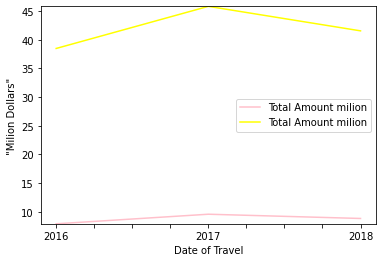

In [572]:
ax=Pink_yearly_income.plot(color='pink',x='Date of Travel',y='Total Amount milion',ylim=(Yearly_income['Total Amount milion'].min(),Yearly_income['Total Amount milion'].max()))

Yellow_yearly_income.plot(ax=ax,color='yellow',x='Date of Travel',y='Total Amount milion',ylim=(Yearly_income['Total Amount milion'].min(),Yearly_income['Total Amount milion'].max()))
ax.set( ylabel='"Milion Dollars"')
plt.show()

This shows a meaningfull difference in Pink and Yellow Cab incomes where both reach to a peak in 2017 and Yello Cab is capturing 5 times more than the Pink Cab

When it comes to yearly costs , Yellow cab has also around 5 times more expenses than Pink Cab as the following plot

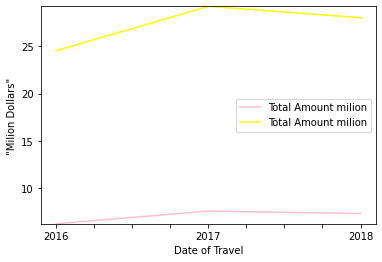

In [573]:
ax=Pink_yearly_cost.plot(color='pink',x='Date of Travel',y='Total Amount milion',ylim=(Yearly_cost['Total Amount milion'].min(),Yearly_cost['Total Amount milion'].max()))

Yellow_yearly_cost.plot(ax=ax,color='yellow',x='Date of Travel',y='Total Amount milion',ylim=(Yearly_cost['Total Amount milion'].min(),Yearly_cost['Total Amount milion'].max()))
ax.set( ylabel='"Milion Dollars"')
plt.show()

Both Companies can be compared also on monthly basis.Monthly income of the both companies on the monthly basis fluctuats similarly and will be like:

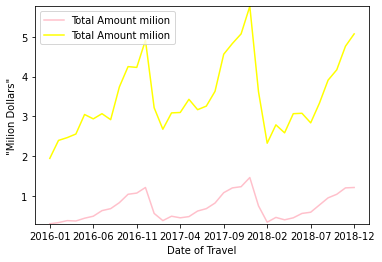

In [574]:
ax=Pink_monthly_income.plot(color='pink',x='Date of Travel',y='Total Amount milion',ylim=(monthly_income['Total Amount milion'].min(),monthly_income['Total Amount milion'].max()))

Yellow_monthly_income.plot(ax=ax,color='yellow',x='Date of Travel',y='Total Amount milion',ylim=(monthly_income['Total Amount milion'].min(),monthly_income['Total Amount milion'].max()))
ax.set( ylabel='"Milion Dollars"')
plt.show()

and similarly monthly cost of the companies is like

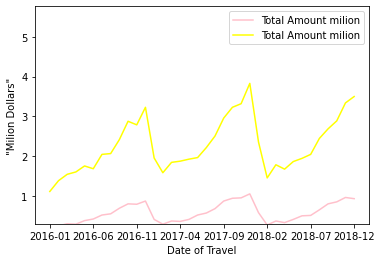

In [575]:
ax=Pink_monthly_cost.plot(color='pink',x='Date of Travel',y='Total Amount milion',ylim=(monthly_income['Total Amount milion'].min(),monthly_income['Total Amount milion'].max()))

Yellow_monthly_cost.plot(ax=ax,color='yellow',x='Date of Travel',y='Total Amount milion',ylim=(monthly_income['Total Amount milion'].min(),monthly_income['Total Amount milion'].max()))
ax.set( ylabel='"Milion Dollars"')
plt.show()

and more importantly monthly revenue of the companies ( revenue =monthly income  -  monthly cost ) will be like 

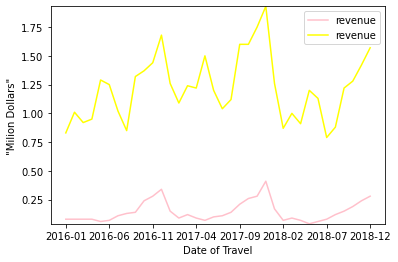

In [576]:
ax=Pink_monthly_income.plot(color='pink',x='Date of Travel',y='revenue',ylim=(monthly_income['revenue'].min(),monthly_income['revenue'].max()))

Yellow_monthly_income.plot(ax=ax,color='yellow',x='Date of Travel',y='revenue',ylim=(monthly_income['revenue'].min(),monthly_income['revenue'].max()))
ax.set( ylabel='"Milion Dollars"')
plt.show()

what is clear is that the Yellow cab is larger in term of profit on mothly basis as well as yearly basis(below). to sum up, in term of profit, The yellow company is better around 8 times than the Pink Cab. also the Pink Cab reaches to almost a very low revenue on some months while the Yellow cab was always better Profitting during these period of investigation

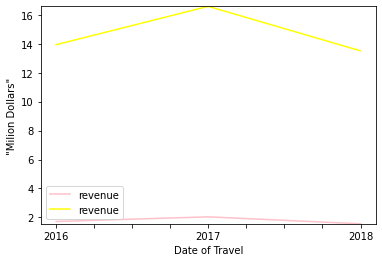

In [577]:
ax=Pink_yearly_income.plot(color='pink',x='Date of Travel',y='revenue',ylim=(Yearly_income['revenue'].min(),Yearly_income['revenue'].max()))

Yellow_yearly_income.plot(ax=ax,color='yellow',x='Date of Travel',y='revenue',ylim=(Yearly_income['revenue'].min(),Yearly_income['revenue'].max()))
ax.set( ylabel='"Milion Dollars"')
plt.show()


......................................................................................


**2nd Hypothesis : Are there Customers that Prefer one Company to another ?  **




.....................................................................................


knowing one company is more profiitting than another can depend on many factor, but one important factor is how many users it has comparing to its rivals.

lets see which company has the maximum cab users. Number of uniqueu sers in entire Pink and Yellow Database are:

In [578]:
master_df['Customer ID'].nunique()

46148

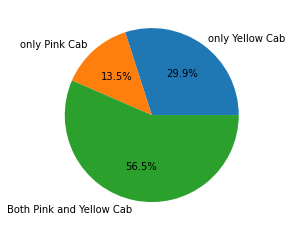

In [579]:
#only pink users
company_userids=master_df.loc[((master_df['Company'] == 'Pink Cab') | (master_df['Company'] == 'Yellow Cab'))].drop(columns=['Transaction ID',	'Date of Travel',		'City'	,'KM Travelled',	'Price Charged'	,'Cost of Trip'	 ,	'Payment_Mode',	'Gender',	'Age'	,'Income (USD/Month)',	'Population',	'Users'])
yellow_users=company_userids.loc[((company_userids['Company']!='Pink Cab') & (company_userids['Company']=='Yellow Cab' ))]
yellow_users_list=yellow_users['Customer ID'].tolist()
only_pinks=company_userids[company_userids['Customer ID'].isin(yellow_users_list)==False]
only_pinks=only_pinks.drop_duplicates('Customer ID', keep ='last')

#only yellow users
pink_users=company_userids.loc[((company_userids['Company']=='Pink Cab') & (company_userids['Company']!='Yellow Cab' ))]
pink_users_list=pink_users['Customer ID'].tolist()
only_yellows=company_userids[company_userids['Customer ID'].isin(pink_users_list)==False]
only_yellows=only_yellows.drop_duplicates('Customer ID', keep ='last')

#both pink and yellows
both_users=company_userids[(company_userids['Customer ID'].isin(pink_users_list)) & (company_userids['Customer ID'].isin(yellow_users_list))]
both_users=both_users.drop_duplicates('Customer ID', keep ='last')

y = [only_yellows['Customer ID'].nunique(), 
                 only_pinks['Customer ID'].nunique(),
                 both_users['Customer ID'].nunique()]
mylabels = ["only Yellow Cab", "only Pink Cab", "Both Pink and Yellow Cab"]

plt.pie(y, labels = mylabels,autopct='%1.1f%%')
plt.show() 

It turns out that Pink cab has around half of unique users of the yellow cab's unique users ( users who do not use the other company ) and obviously it can be deduced that the Yellow Cab has more users, but the difference in number of unique users is not too much to contribute in more profit of the Yellow cab. In other words, there are users of Pink Cab that are more willing to use the Yellow cab while they are also Pink Cab customers, but there must be something more that makes Yellow cab more profitting ,Lets investigate more

....................................................................................

3rd Hypothesis : Is the use of the Cab companies consistent during diffent months of the year ?

.....................................................................................



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


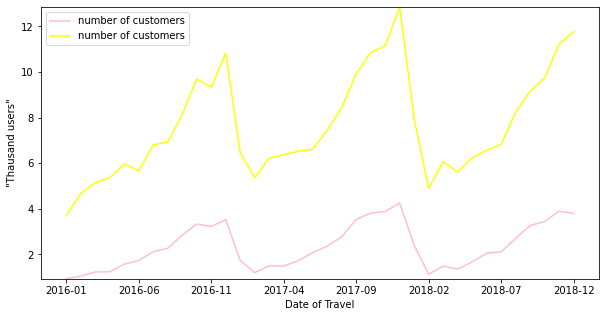

In [580]:
users_travels=master_df.loc[((master_df['Company'] == 'Pink Cab') | (master_df['Company'] == 'Yellow Cab'))].drop(columns=['Transaction ID',	'City'	,'KM Travelled',	'Price Charged'	,'Cost of Trip'	 ,	'Payment_Mode',	'Gender',	'Age'	,'Income (USD/Month)',	'Population',	'Users'])

number_of_users=users_travels.groupby([users_travels['Date of Travel'].dt.strftime('%Y-%m'),'Company'])['Customer ID'].count().reset_index(name ='number of customers')
Yellow_monthly_users=number_of_users[number_of_users['Company'] == "Yellow Cab"]
Pink_monthly_users=number_of_users[number_of_users['Company'] == "Pink Cab"]

Yellow_monthly_users['number of customers']=Yellow_monthly_users['number of customers'].div(1000).round(2)
Pink_monthly_users['number of customers']=Pink_monthly_users['number of customers'].div(1000).round(2)
max_users=np.maximum(Pink_monthly_users['number of customers'].max(),Yellow_monthly_users['number of customers'].max())
min_users=np.minimum(Pink_monthly_users['number of customers'].min(),Yellow_monthly_users['number of customers'].min())
ax=Pink_monthly_users.plot(figsize=(10,5),color='pink',x='Date of Travel',y='number of customers',ylim=(min_users,max_users))
Yellow_monthly_users.plot(ax=ax,figsize=(10,5) ,color='yellow',x='Date of Travel',y='number of customers',ylim=(min_users,max_users))
ax.set( ylabel='"Thausand users"')
plt.show()

.....................................................................................


** 4th Hypothesis : Do Holidays have any effect in number of travels made by customers in the specifc time periods?  **

.....................................................................................

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


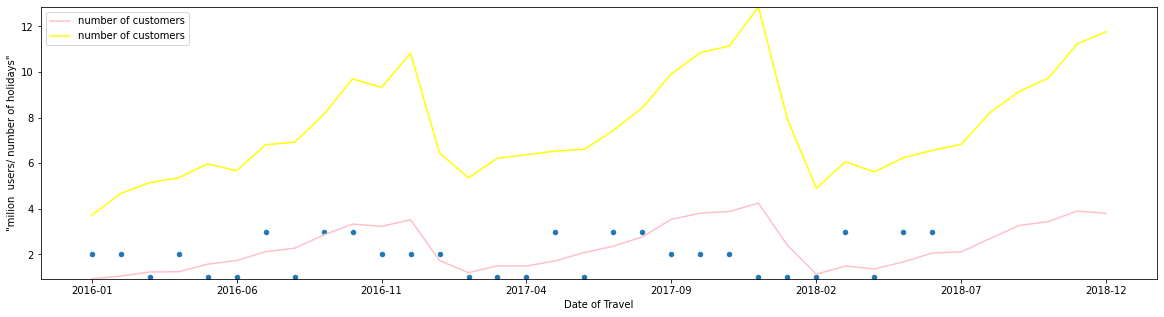

In [581]:
group_holidays=holidays_df.groupby([holidays_df['Date of Travel'].dt.strftime('%Y-%m')]).count().drop(columns=['Date of Travel'])
group_holidays['Date of Travel']=group_holidays.index


users_travels=master_df.loc[((master_df['Company'] == 'Pink Cab') | (master_df['Company'] == 'Yellow Cab'))].drop(columns=['Transaction ID',	'City'	,'KM Travelled',	'Price Charged'	,'Cost of Trip'	 ,	'Payment_Mode',	'Gender',	'Age'	,'Income (USD/Month)',	'Population',	'Users'])

number_of_users=users_travels.groupby([users_travels['Date of Travel'].dt.strftime('%Y-%m'),'Company'])['Customer ID'].count().reset_index(name ='number of customers')
Yellow_monthly_users=number_of_users[number_of_users['Company'] == "Yellow Cab"]
Pink_monthly_users=number_of_users[number_of_users['Company'] == "Pink Cab"]

Yellow_monthly_users['number of customers']=Yellow_monthly_users['number of customers'].div(1000).round(2)
Pink_monthly_users['number of customers']=Pink_monthly_users['number of customers'].div(1000).round(2)
max_users=np.maximum(Pink_monthly_users['number of customers'].max(),Yellow_monthly_users['number of customers'].max())
min_users=np.minimum(Pink_monthly_users['number of customers'].min(),Yellow_monthly_users['number of customers'].min())

ax=Pink_monthly_users.plot(figsize=(20,5),color='pink',x='Date of Travel',y='number of customers',ylim=(min_users,max_users))
ax2=Yellow_monthly_users.plot(ax=ax,figsize=(20,5) ,color='yellow',x='Date of Travel',y='number of customers',ylim=(min_users,max_users))
group_holidays.plot.scatter(x='Date of Travel',y='Holiday',ax=ax2)
ax.set( ylabel='"milion  users/ number of holidays"')

plt.show()

as shown the graph, it seems that there is a relation in the number of holidays in month and the increase in users of the both companies. the closer and more the holidays are, the number of users of the both companies tend to use them more and they are affected with almost the same pattern.

..........................................................................................



**5th  Hypothesis ** : Does margin proportionally increase with increase in number of customers? 

..........................................................................................

 comparing each company's monthly income wwith nummber of their monthly users

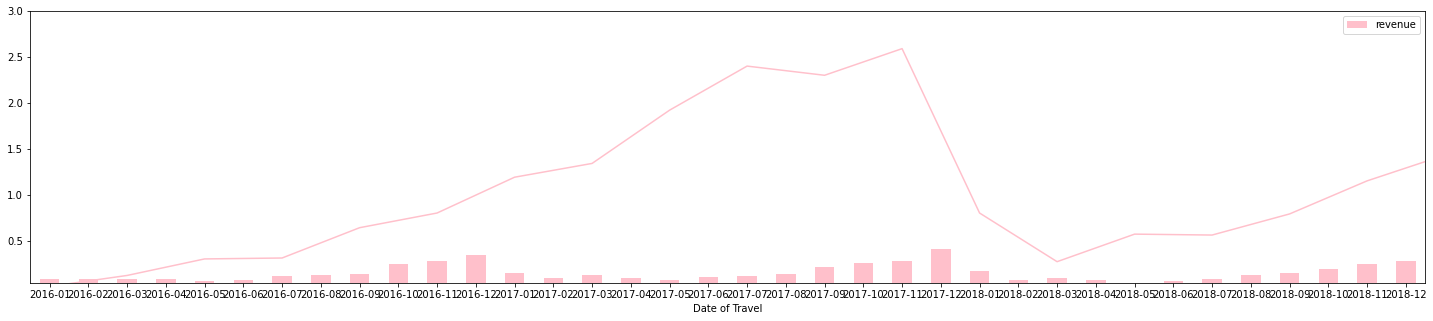

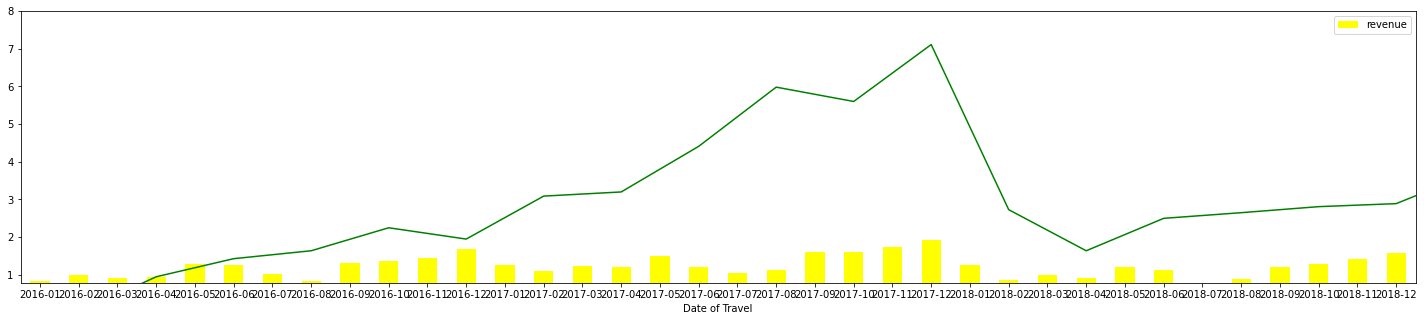

In [582]:
max=Pink_monthly_users['number of customers'].max()
min=Pink_monthly_income['revenue'].min()
ax=Pink_monthly_income.plot.bar(color='pink',x='Date of Travel',y='revenue',ylim=(min,3))

(Pink_monthly_users['number of customers']-Pink_monthly_users['number of customers'].min()).plot(ax=ax,figsize=(25,5),color='pink',x='Date of Travel',y='number of customers',ylim=(min,3))


max=Yellow_monthly_users['number of customers'].max()
min=Yellow_monthly_income['revenue'].min()
ax=Yellow_monthly_income.plot.bar(color='yellow',x='Date of Travel',y='revenue',ylim=(min,8))
(Yellow_monthly_users['number of customers']-Yellow_monthly_users['number of customers'].min()).plot(ax=ax,figsize=(25,5),color='green',x='Date of Travel',y='number of customers',ylim=(min,8))

as it is expected number of rides have relation with amount of revenue


**What are attributes of Customer Segments:**

**6th Hypothesis**: how different attributes of the cutomer segments affect the business?
different examples such as 
is Pink Cab invested enough in other cities ? for example , is all Pink Cab's revenue  from one city and not invested enough in other cities ?

.

or is there any gender/Age group  that is not willing to use the the company ? ( are genders equally devided for each company ? (evaluation based on unique users not number of rides )

.

or is there any problem related to Payment Mode ? do People use the same proportion of payment Mode for both companies ?

 Lets investigate which company is leading in different cities?

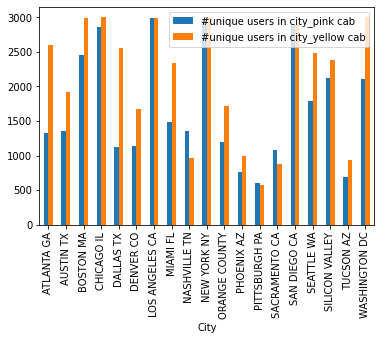

In [583]:
city_company=master_df.loc[((master_df['Company'] == 'Pink Cab') | (master_df['Company'] == 'Yellow Cab'))].drop(
    columns=['Transaction ID'	,'Date of Travel',	'KM Travelled',	'Price Charged'	,'Cost of Trip'	, 	
             'Payment_Mode',	'Gender',	'Age',	'Income (USD/Month)',	'Population'	,'Users'])

pink_cities=city_company[city_company['Company']=='Pink Cab'].drop_duplicates('Customer ID',keep='first').groupby(['City'])['Customer ID'].nunique().reset_index(name ='#unique users in city')
yellow_cities=city_company[city_company['Company']=='Yellow Cab'].drop_duplicates('Customer ID',keep='first').groupby(['City'])['Customer ID'].nunique().reset_index(name ='#unique users in city')
pd.merge(pink_cities,yellow_cities,on='City',suffixes=('_pink cab', '_yellow cab')).plot(x="City", y=['#unique users in city_pink cab',	'#unique users in city_yellow cab'], kind="bar")

It turns out that Pink Cab is having almost as unique users as Yellow cab in cities like Chicago ,LA,NY, and San Diego and even slightly more users in Yellow cab in some cities Sacramento and Nashvile , but less unique users in other cities.

From this, one can deduce that people are less willing to comeback to Pink cab despite they know this company

what about different genders?

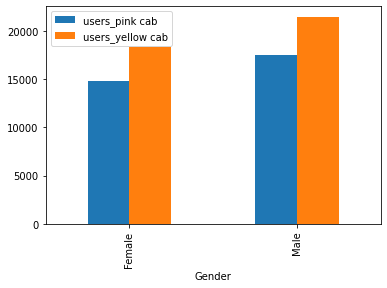

In [584]:
gender=master_df.loc[((master_df['Company'] == 'Pink Cab') | (master_df['Company'] == 'Yellow Cab'))].drop(
    columns=['Transaction ID'	,'Date of Travel',	'KM Travelled',	'Price Charged'	,'Cost of Trip'	, 	
             'Payment_Mode',	'City',	'Age',	'Income (USD/Month)',	'Population'	,'Users'])
pink_gender=city_company[city_company['Company']=='Pink Cab'].drop_duplicates('Customer ID',keep='first').groupby(['City'])['Customer ID'].nunique().reset_index(name ='#unique users in city')
yellow_gender=city_company[city_company['Company']=='Yellow Cab'].drop_duplicates('Customer ID',keep='first').groupby(['City'])['Customer ID'].nunique().reset_index(name ='#unique users in city')


pink_gender=gender[city_company['Company']=='Pink Cab'].drop_duplicates('Customer ID',keep='first').drop(
    columns=['Customer ID']).groupby(['Gender']).count().reset_index().rename(columns={'Company':'users'})

yellow_gender=gender[city_company['Company']=='Yellow Cab'].drop_duplicates('Customer ID',keep='first').drop(
    columns=['Customer ID']).groupby(['Gender']).count().reset_index().rename(columns={'Company':'users'})



pd.merge(pink_gender,yellow_gender,on='Gender',suffixes=('_pink cab', '_yellow cab')).plot(x="Gender", y=['users_pink cab',	'users_yellow cab'], kind="bar")    


gender gap is not a big deal for both company as the plot shows that both male and female users show the same propotional interest to both companies. in other words for each company, there is no gap in number of users ( though male users in both companies are slightly more )

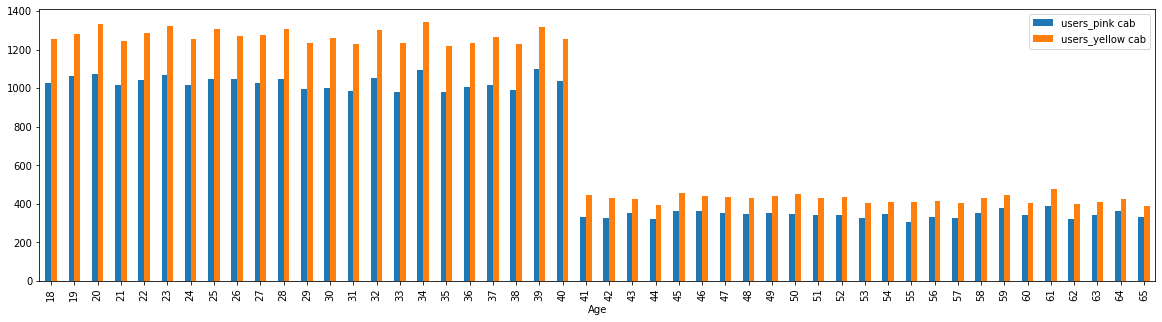

In [585]:
age=master_df.loc[((master_df['Company'] == 'Pink Cab') | (master_df['Company'] == 'Yellow Cab'))].drop(
    columns=['Transaction ID'	,'Date of Travel',	'KM Travelled',	'Price Charged'	,'Cost of Trip'	, 	
             'Payment_Mode',	'City',	'Gender',	'Income (USD/Month)',	'Population'	,'Users'])


pink_age=age[age['Company']=='Pink Cab'].drop_duplicates('Customer ID',keep='first').drop(
    columns=['Customer ID']).groupby(['Age']).count().reset_index().rename(columns={'Company':'users'})

yellow_age=age[age['Company']=='Yellow Cab'].drop_duplicates('Customer ID',keep='first').drop(
    columns=['Customer ID']).groupby(['Age']).count().reset_index().rename(columns={'Company':'users'})



pd.merge(pink_age,yellow_age,on='Age',suffixes=('_pink cab', '_yellow cab')).plot(x="Age", y=['users_pink cab',	'users_yellow cab'], kind="bar",figsize=(20,5))    

also different age groups are treating both companies almost the same way and people younger than 40 years old are leading in both companies

and finally as the following plot shows , the payments made with the credit cards are preffered in both companies , and as it is expected pink cab transactions made with bode card and cash are less than Yellow cabs

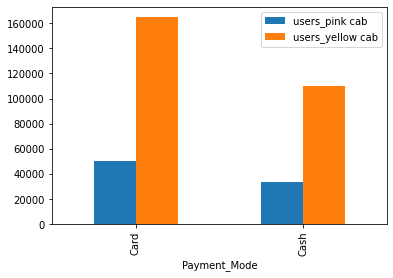

In [586]:
payment=master_df.loc[((master_df['Company'] == 'Pink Cab') | (master_df['Company'] == 'Yellow Cab'))].drop(
    columns=['Transaction ID'	,'Date of Travel',	'KM Travelled',	'Price Charged'	,'Cost of Trip'	, 	
             'Age',	'City',	'Gender',	'Income (USD/Month)',	'Population'	,'Users'])


pink_payment=payment[payment['Company']=='Pink Cab'].drop(columns=['Customer ID']).groupby(['Payment_Mode']).count().reset_index().rename(columns={'Company':'users'})

yellow_payment=payment[payment['Company']=='Yellow Cab'].drop(columns=['Customer ID']).groupby(['Payment_Mode']).count().reset_index().rename(columns={'Company':'users'})



pd.merge(pink_payment,yellow_payment,on='Payment_Mode',suffixes=('_pink cab', '_yellow cab')).plot(x="Payment_Mode", y=['users_pink cab',	'users_yellow cab'], kind="bar")

**7th Hypothesis : does Yellow have lower/higher price per KM which results in more profit due to its more customers ?**

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


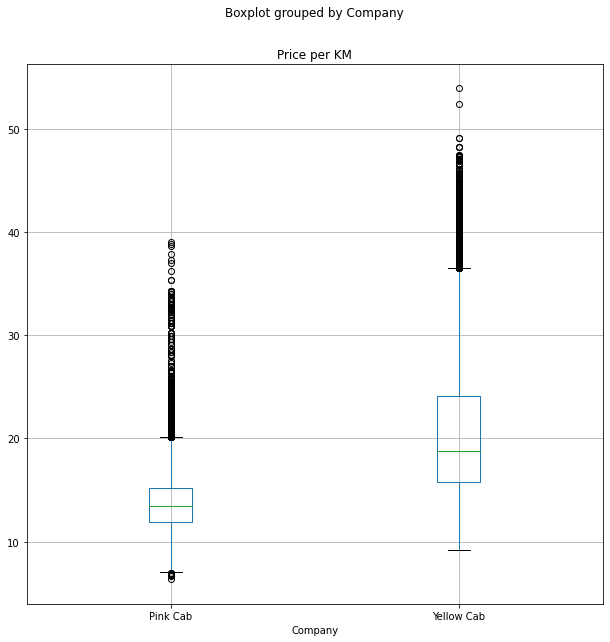

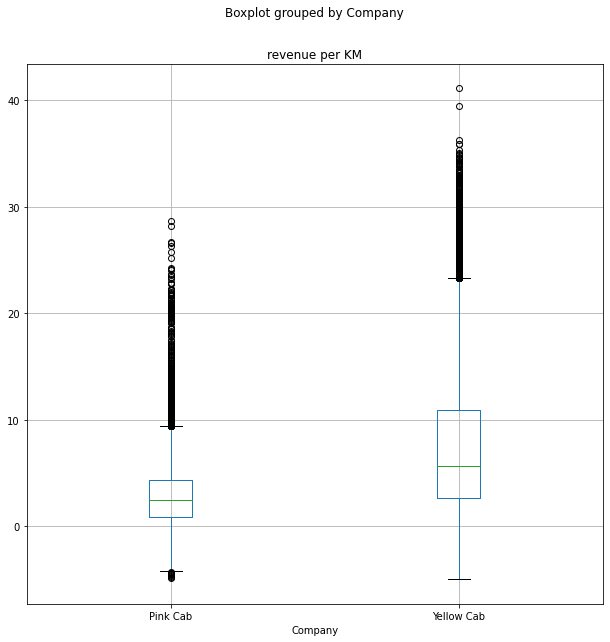

In [587]:
ppkm=master_df.loc[((master_df['Company'] == 'Pink Cab') | (master_df['Company'] == 'Yellow Cab'))].drop(
    columns=['Date of Travel','Transaction ID',	'City'	 ,	'Payment_Mode',	'Gender',	'Age'	,'Income (USD/Month)',	'Population',	'Users'])
ppkm['Price per KM']=ppkm['Price Charged']/ppkm['KM Travelled']
ppkm['revenue per KM']=((ppkm['Price Charged']-ppkm['Cost of Trip'])/ppkm['KM Travelled'])

ppkm.boxplot(by='Company',column=['Price per KM'],figsize=(10,10))
ppkm.boxplot(by='Company',column=['revenue per KM'],figsize=(10,10))

it turns out that despite having higher price per KM and consequently higher revenue per KM for Yellow cab, people still prefer to use the Yellow cab which is interesting. so the less prices of Pink cab has not attracted its customers enough to use Pink Cab more. 
.


Note: however this should be considered into account that Pink cab might be less used due to unavailability or lack of taxis comparing to its competing company, but this issue cannot be investigated based on the information we have.

...................................................................

Hypothesis 8 : one company has more loyal customers than the other 

....................................................................

it is also interesting to check the customers loyality considering howmany customers return to the cab companies for their rides. it is interesting that as the below plot illustrates , despite both companies serve major of their customers with only single ride, and even pink cab excels yellow cab in single rides, but yellow cab is more furtunate to have thier customers back for their futures rides.
to be more spicif, customers are tend to use Yellow cab for their 12th ride and more, while Pink cab is not fortunate to serve customers for more  rides.

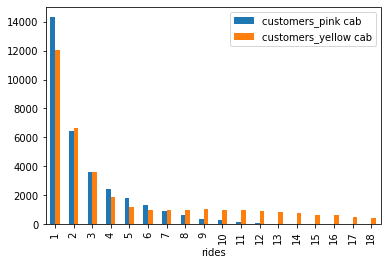

In [588]:
pnr=master_df.loc[(master_df['Company'] == 'Pink Cab')].groupby('Customer ID')['Transaction ID'].size().reset_index(name='rides')
pnrr=pnr.groupby('rides').size().reset_index(name='customers')
ynr=master_df.loc[(master_df['Company'] == 'Yellow Cab')].groupby('Customer ID')['Transaction ID'].size().reset_index(name='rides')
ynrr=ynr.groupby('rides').size().reset_index(name='customers')
pd.merge(pnrr,ynrr,on='rides',suffixes=('_pink cab', '_yellow cab')).plot(x='rides', y=['customers_pink cab',	'customers_yellow cab'], kind="bar") 


9th hypothesis: Are the rides seasonal in cities depending on the weather condition ?

.....................................................................................

lets evaluate if seasonality in a city such as NY where both companies perform the same in term of number of unique users have any impact. from the plots its clear that rides for both companies in newyork are seasonal(fluctuates ) but depending on the weather condition , it seems people use cabs when the weather is snowy.

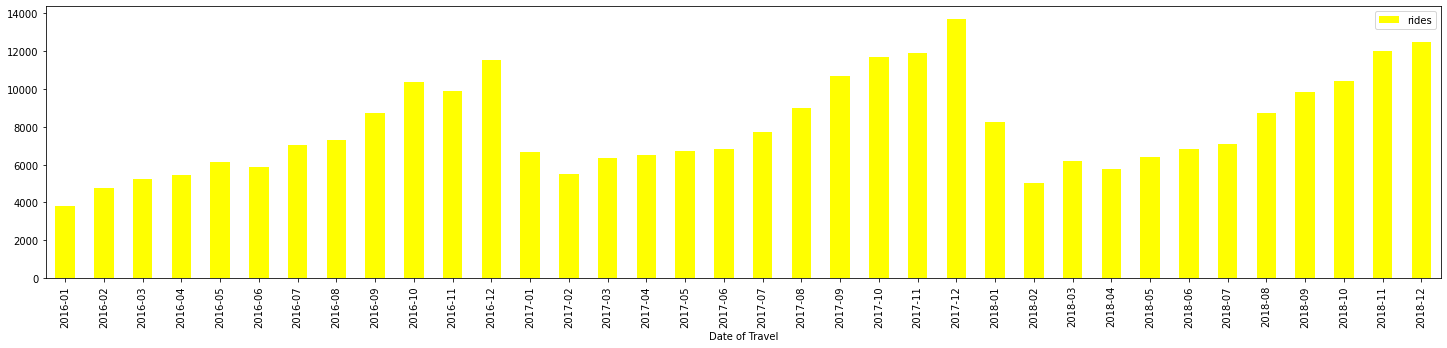

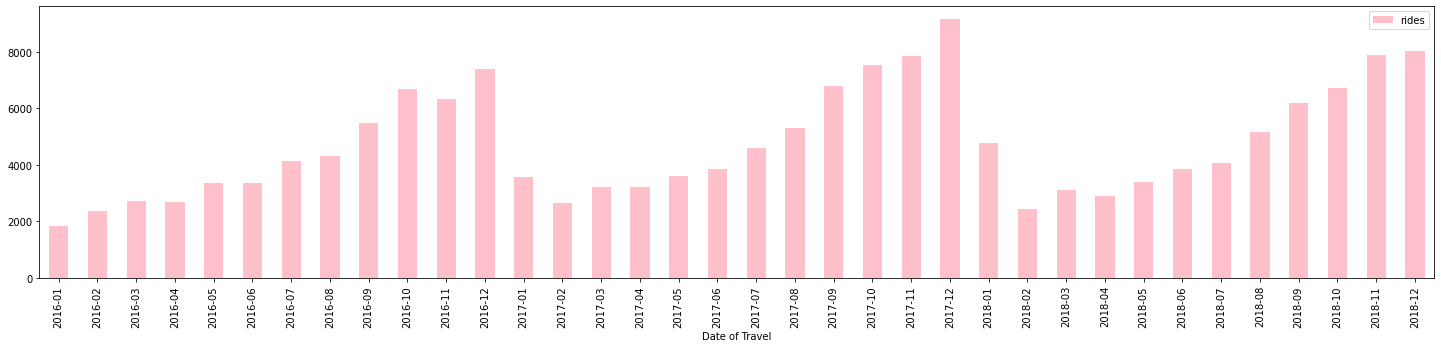

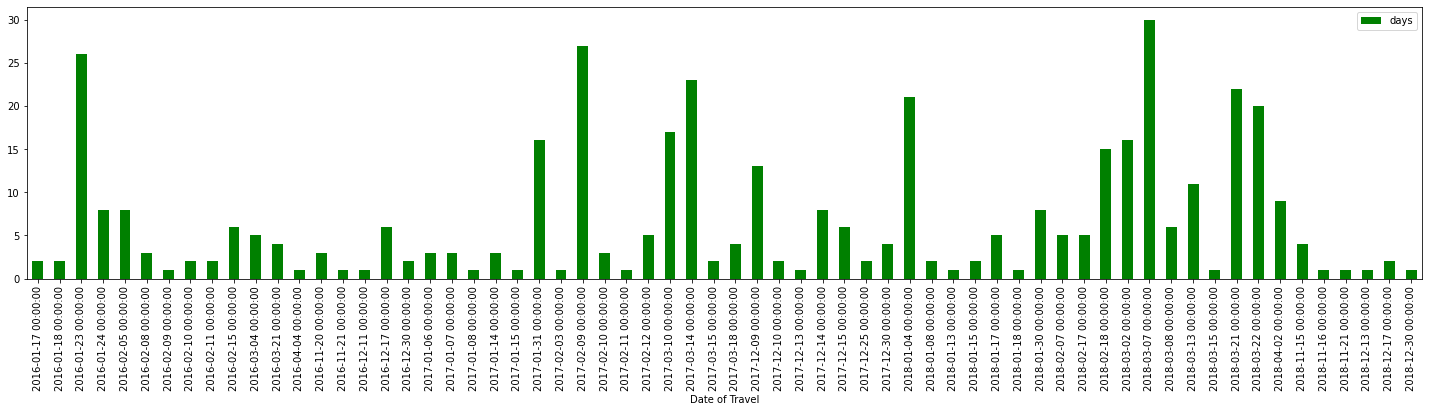

In [558]:
ynr=master_df.loc[(master_df['Company'] == 'Yellow Cab')| (master_df['City'] == 'NEW YORK NY')].groupby(master_df['Date of Travel'].dt.strftime('%Y-%m'))['Transaction ID'].size().reset_index(name='rides')
ynr.plot.bar(x='Date of Travel',y='rides',figsize=(25,5),color='Yellow')

pnr=master_df.loc[(master_df['Company'] == 'Pink Cab')| (master_df['City'] == 'NEW YORK NY')].groupby(master_df['Date of Travel'].dt.strftime('%Y-%m'))['Transaction ID'].size().reset_index(name='rides')
pnr.plot.bar(x='Date of Travel',y='rides',figsize=(25,5),color='pink')

weather_df_ny=weather_df.loc[(weather_df['City'] == 'NEW YORK NY')].drop(columns=['City'])
weather_df_ny['Date of Travel']=pd.to_datetime(weather_df_ny['Date of Travel'])
weather_df_ny=weather_df_ny.groupby(['Date of Travel','Type']).size().reset_index(name='days')
weather_df_ny.loc[(weather_df_ny['Type'] == 'Snow') ].plot.bar(x='Date of Travel',y='days',figsize=(25,5),color='green')


and Finally based on the above finding It is  recommended to  the XYZ company to invest on Yellow cab, as it has more loyal customers , is more profitting , already more popular in most of the major cities are having more customers depite its higher prices per KM